In [3]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

df = pd.read_csv('result/data/melting_point_features.csv')

y = df['Tm']
X = df.drop(columns=['Tm'])

X = X.select_dtypes(include=[np.number])
X.replace([np.inf, -np.inf], np.nan, inplace=True)

imputer = SimpleImputer(strategy='median')
X_clean = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42)

base_model = LGBMRegressor(random_state=42, n_jobs=1)

In [4]:
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

train_data = X_train.copy()
train_data['Tm'] = y_train

print(f"Số lượng mẫu trước khi lọc: {len(train_data)}")
train_data_clean = remove_outliers(train_data, 'Tm')
print(f"Số lượng mẫu sau khi lọc: {len(train_data_clean)}")

X_train_clean = train_data_clean.drop(columns=['Tm'])
y_train_clean = train_data_clean['Tm']

Số lượng mẫu trước khi lọc: 8416
Số lượng mẫu sau khi lọc: 8109



---START RFE ---
Fitting estimator with 937 features.
Fitting estimator with 917 features.
Fitting estimator with 897 features.
Fitting estimator with 877 features.
Fitting estimator with 857 features.
Fitting estimator with 837 features.
Fitting estimator with 817 features.
Fitting estimator with 797 features.
Fitting estimator with 777 features.
Fitting estimator with 757 features.
Fitting estimator with 737 features.
Fitting estimator with 717 features.
Fitting estimator with 697 features.
Fitting estimator with 677 features.
Fitting estimator with 657 features.
Fitting estimator with 637 features.
Fitting estimator with 617 features.
Fitting estimator with 597 features.
Fitting estimator with 577 features.
Fitting estimator with 557 features.
Fitting estimator with 537 features.
Fitting estimator with 517 features.
Fitting estimator with 497 features.
Fitting estimator with 477 features.
Fitting estimator with 457 features.
Fitting estimator with 437 features.
Fitting estimator wi

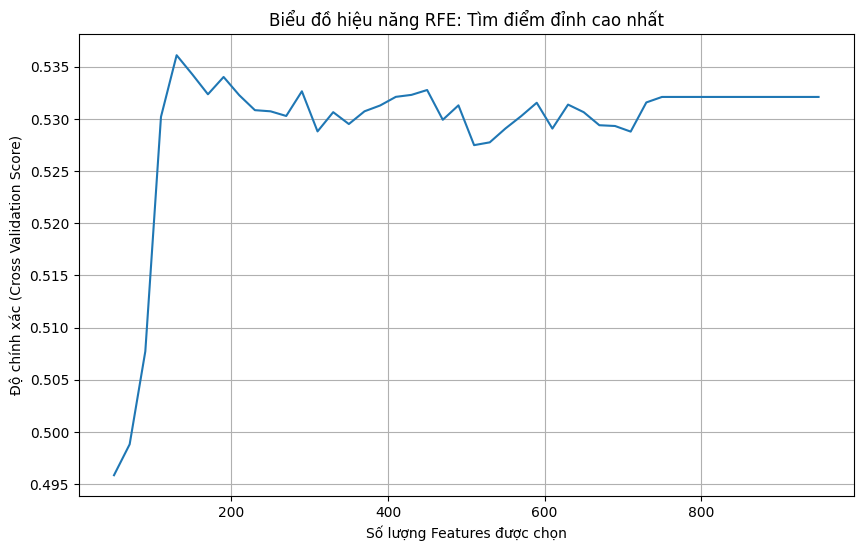


✅ Danh sách features được chọn:
['MaxAbsEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'NumValenceElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0n', 'Chi0v', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n', 'HallKierAlpha', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA5', 'SMR_VSA6', 'SlogP_VSA1', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA5', 'SlogP_VSA9', 'TPSA', 'EState_VSA1', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'VSA_EState1', 'VSA_E

In [6]:
from sklearn.feature_selection import RFECV
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import time
import pandas as pd

print("\n---START RFE ---")
start = time.time()

model = LGBMRegressor(n_estimators=1000,
    learning_rate=0.01,
    num_leaves=50,
    max_depth=-1,
    random_state=2106,
    n_jobs=1,
    verbose=-1)

rfecv = RFECV(
    estimator=model,
    step=20,
    cv=3,
    scoring='r2',
    min_features_to_select=50,
    n_jobs=-1,
    verbose=1
    )

rfecv.fit(X_train, y_train)

selected_rfecv = X_train.columns[rfecv.support_]
print(f"⏱️ Time Run: {time.time() - start:.2f} s")

n_scores = len(rfecv.cv_results_['mean_test_score'])
plt.figure(figsize=(10, 6))
plt.xlabel("Số lượng Features được chọn")
plt.ylabel("Độ chính xác (Cross Validation Score)")

x_points = range(50, 50 + n_scores * 20, 20) 
plt.plot(x_points, rfecv.cv_results_['mean_test_score'])
plt.title('Biểu đồ hiệu năng RFE: Tìm điểm đỉnh cao nhất')
plt.grid(True)
plt.show()

print("\n✅ Danh sách features được chọn:")
print(list(selected_rfecv))